In [125]:
import gensim
from matplotlib import pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pickle
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation

In [9]:
data = pd.read_hdf('census-wordlist.hdf')

In [10]:
data

,sex,age,occupation,numPeople,reg,unmodified,synonym_list,unmodified_synonym_list,additional_synonyms,additional_unmodified_synonyms
0,female,o20,Egg-merchant and Dealer,37.0,"Egg merchant,Egg dealer,Dealer in eggs","Merchant,Dealer","[Egg merchant, Egg dealer, Dealer in eggs]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
1,female,u19,Egg-merchant and Dealer,3.0,"Egg merchant,Egg dealer,Dealer in eggs","Merchant,Dealer","[Egg merchant, Egg dealer, Dealer in eggs]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
2,male,o20,Egg-merchant and Dealer,136.0,"Egg merchant,Egg dealer,Dealer in eggs","Merchant,Dealer","[Egg merchant, Egg dealer, Dealer in eggs]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
3,male,u19,Egg-merchant and Dealer,10.0,"Egg merchant,Egg dealer,Dealer in eggs","Merchant,Dealer","[Egg merchant, Egg dealer, Dealer in eggs]","[Merchant, Dealer]",[],"[merchant, merchandiser, trader, bargainer, de..."
4,female,o20,Embosser,14.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
5,female,u19,Embosser,4.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
6,male,o20,Embosser,54.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
7,male,u19,Embosser,6.0,Embosser,Embosser,[Embosser],[Embosser],[],[]
8,female,o20,Embroiderer,593.0,Embroiderer,Embroiderer,[Embroiderer],[Embroiderer],[embroiderer],[embroiderer]
9,female,u19,Embroiderer,209.0,Embroiderer,Embroiderer,[Embroiderer],[Embroiderer],[embroiderer],[embroiderer]


In [11]:
#corpus = pd.read_hdf('corpus/pr-1840-1860-texts.hdf')
#alltext = []
#for i, row in corpus.iterrows():
#    text = row['text']
#    alltext.append(text)
#alltext = ''.join(alltext).lower()
f = open('bl-all.txt')
alltext = f.read()

In [12]:
name_dict = {}
r = re.compile(r'[^a-zA-Z_]+')
for i, row in data.iterrows():
    name = row['occupation']
    name_token = name.lower().replace(' ', '_')
    name_token = r.sub('', name_token)
    if name not in name_dict:
        name_dict[name] = (name_token, set())
    name_dict[name][1].update(row['synonym_list'])

In [13]:
name_dict['Carpenter and Joiner']

('carpenter_and_joiner', {'Carpenter', 'Joiner'})

In [15]:
# Replace all instances of the synonyms with the occupation name token (so that 'carpenter' becomes
# 'carpenter_and_joiner').  Only regular plurals are handled properly.
patterns = set()
sub_dict = {}
for name in name_dict:
    name_token, syns = name_dict[name]
    for syn in syns:
        syn = syn.lower()
        patterns.add(re.escape(syn).replace(r'\ ', '[ -]?'))
        sub_dict[syn.replace(' ', '')] = name_token
r = re.compile('([^a-z_])(' + '|'.join(patterns) + ')((e?s)?[^a-z_])')
alltext = r.sub(lambda m: m.group(1) + sub_dict[m.group(2).replace('-', '').replace(' ', '')] + m.group(3), alltext)

In [16]:
alltext = re.sub(r'\[verse\]', '', alltext)
alltext = re.sub(r'//.*$', '', alltext, flags=re.MULTILINE)
alltext = re.sub(r'\\', '', alltext)

In [17]:
sentences = nltk.sent_tokenize(alltext)
allsents = []
for sent in sentences:
    toks = nltk.word_tokenize(sent)
    toks = [tok.lower() for tok in toks if re.match(r'[a-zA-Z]', tok)]
    allsents.append(toks)

In [18]:
f = open('bl-all-processed.txt', 'w')
f.write('\n'.join([' '.join(toks) for toks in allsents]) + '\n')
f = open('bl-all-processed.pkl', 'wb')
pickle.dump(allsents, f)

OSError: [Errno 22] Invalid argument

In [230]:
model = gensim.models.Word2Vec(allsents, size=100, window=5, sg=1, min_count=1, workers=4)

In [231]:
model.save("bl-all.model")

In [232]:
model.wv.most_similar('carpenter_and_joiner')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('blacksmith', 0.8629897832870483),
 ('boot_and_shoemaker', 0.8481932282447815),
 ('wheelwright', 0.8338868618011475),
 ('stone-mason_paviour_and_statuary', 0.8224925994873047),
 ('bricklayer', 0.8191455602645874),
 ('ship_builder_carpenter_and_wright', 0.8034192323684692),
 ('locksmith_and_bellhanger', 0.7993825674057007),
 ('tailor_and_breechesmaker', 0.7962732315063477),
 ('hairdresser_and_barber', 0.793989360332489),
 ('surgeon_apothecary_and_medical_student', 0.7899656295776367)]

In [233]:
model.wv.most_similar('brassfounder_and_moulder')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('managing-clerk', 0.857177734375),
 ('bendaoud', 0.8539769053459167),
 ('pentise', 0.8484739661216736),
 ('announcing—', 0.8464676737785339),
 ('barrow-like', 0.8441565036773682),
 ('humauls', 0.8427817225456238),
 ('tap-room.', 0.8426565527915955),
 ('fire-agency', 0.8415142893791199),
 ('heels—an', 0.8413400650024414),
 ("carrier_carter_and_waggoner's", 0.8410425782203674)]

In [234]:
model.wv.most_similar('artist_fine_arts')

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('painter_plumber_and_glazier', 0.9079660773277283),
 ('artist', 0.822259783744812),
 ('mechanist', 0.8041200041770935),
 ('engraver_all_branches', 0.803713858127594),
 ('sculptor', 0.7976645231246948),
 ('actor_play', 0.7932649850845337),
 ('attorney_solicitor_writer_and_law_student', 0.792335569858551),
 ('musician_and_organist', 0.7880347371101379),
 ('draughtsman', 0.7829408645629883),
 ('colourist', 0.7728814482688904)]

In [235]:
model.wv.most_similar(['king', 'woman'], ['man'])

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.8633107542991638),
 ('princess', 0.8186799883842468),
 ('infanta', 0.7947489023208618),
 ('king-', 0.7914287447929382),
 ('iceni', 0.7905521392822266),
 ('queen-mother', 0.783614456653595),
 ('oueen', 0.7783247232437134),
 ('euzabeth', 0.7776715755462646),
 ('kino-', 0.7774124145507812),
 ('melachlin', 0.7737711668014526)]

In [236]:
occupations_in_corpus = []
for name in name_dict:
    name_tok, _ = name_dict[name]
    try:
        model.wv[name_tok]
    except KeyError:
        continue
    occupations_in_corpus.append(name)
len(occupations_in_corpus)

390

In [237]:
occ_vecs = []
occ_names = []
for name in occupations_in_corpus:
    name_tok, _ = name_dict[name]
    sing_vec = model.wv[name_tok]
    #try:
    #    plur_vec = model.wv[name_tok + 's']
    #except KeyError:
    #    try:
    #        plur_vec = model.wv[name_tok + 'es']
    #    except KeyError:
    #        plur_vec = None
    #if plur_vec is not None:
    #    occ_vecs.append((sing_vec + plur_vec) / 2)
    #else:
    #    occ_vecs.append(sing_vec)
    occ_vecs.append(sing_vec)
    occ_names.append(name)
df = pd.DataFrame(occ_vecs, index=occ_names)

In [260]:
tsne_model = TSNE(n_components=2, random_state=0, perplexity=5, early_exaggeration=3.0, metric="cosine", method="exact", verbose=2)
tsne = tsne_model.fit_transform(df)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 390 / 390
[t-SNE] Mean sigma: 0.078960
[t-SNE] Iteration 50: error = 12.1588922, gradient norm = 0.1405969 (50 iterations in 0.348s)
[t-SNE] Iteration 100: error = 11.6883135, gradient norm = 0.1260422 (50 iterations in 0.351s)
[t-SNE] Iteration 150: error = 11.7027480, gradient norm = 0.1258576 (50 iterations in 0.316s)
[t-SNE] Iteration 200: error = 11.4337853, gradient norm = 0.1144244 (50 iterations in 0.317s)
[t-SNE] Iteration 250: error = 11.3264789, gradient norm = 0.1358051 (50 iterations in 0.337s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 11.326479
[t-SNE] Iteration 300: error = 1.4230587, gradient norm = 0.0044577 (50 iterations in 0.376s)
[t-SNE] Iteration 350: error = 1.3352911, gradient norm = 0.0010773 (50 iterations in 0.454s)
[t-SNE] Iteration 400: error = 1.3042619, gradient norm = 0.0004950 (50 iterations in 0.400s)
[t-SNE] Iteration 450: error = 1.

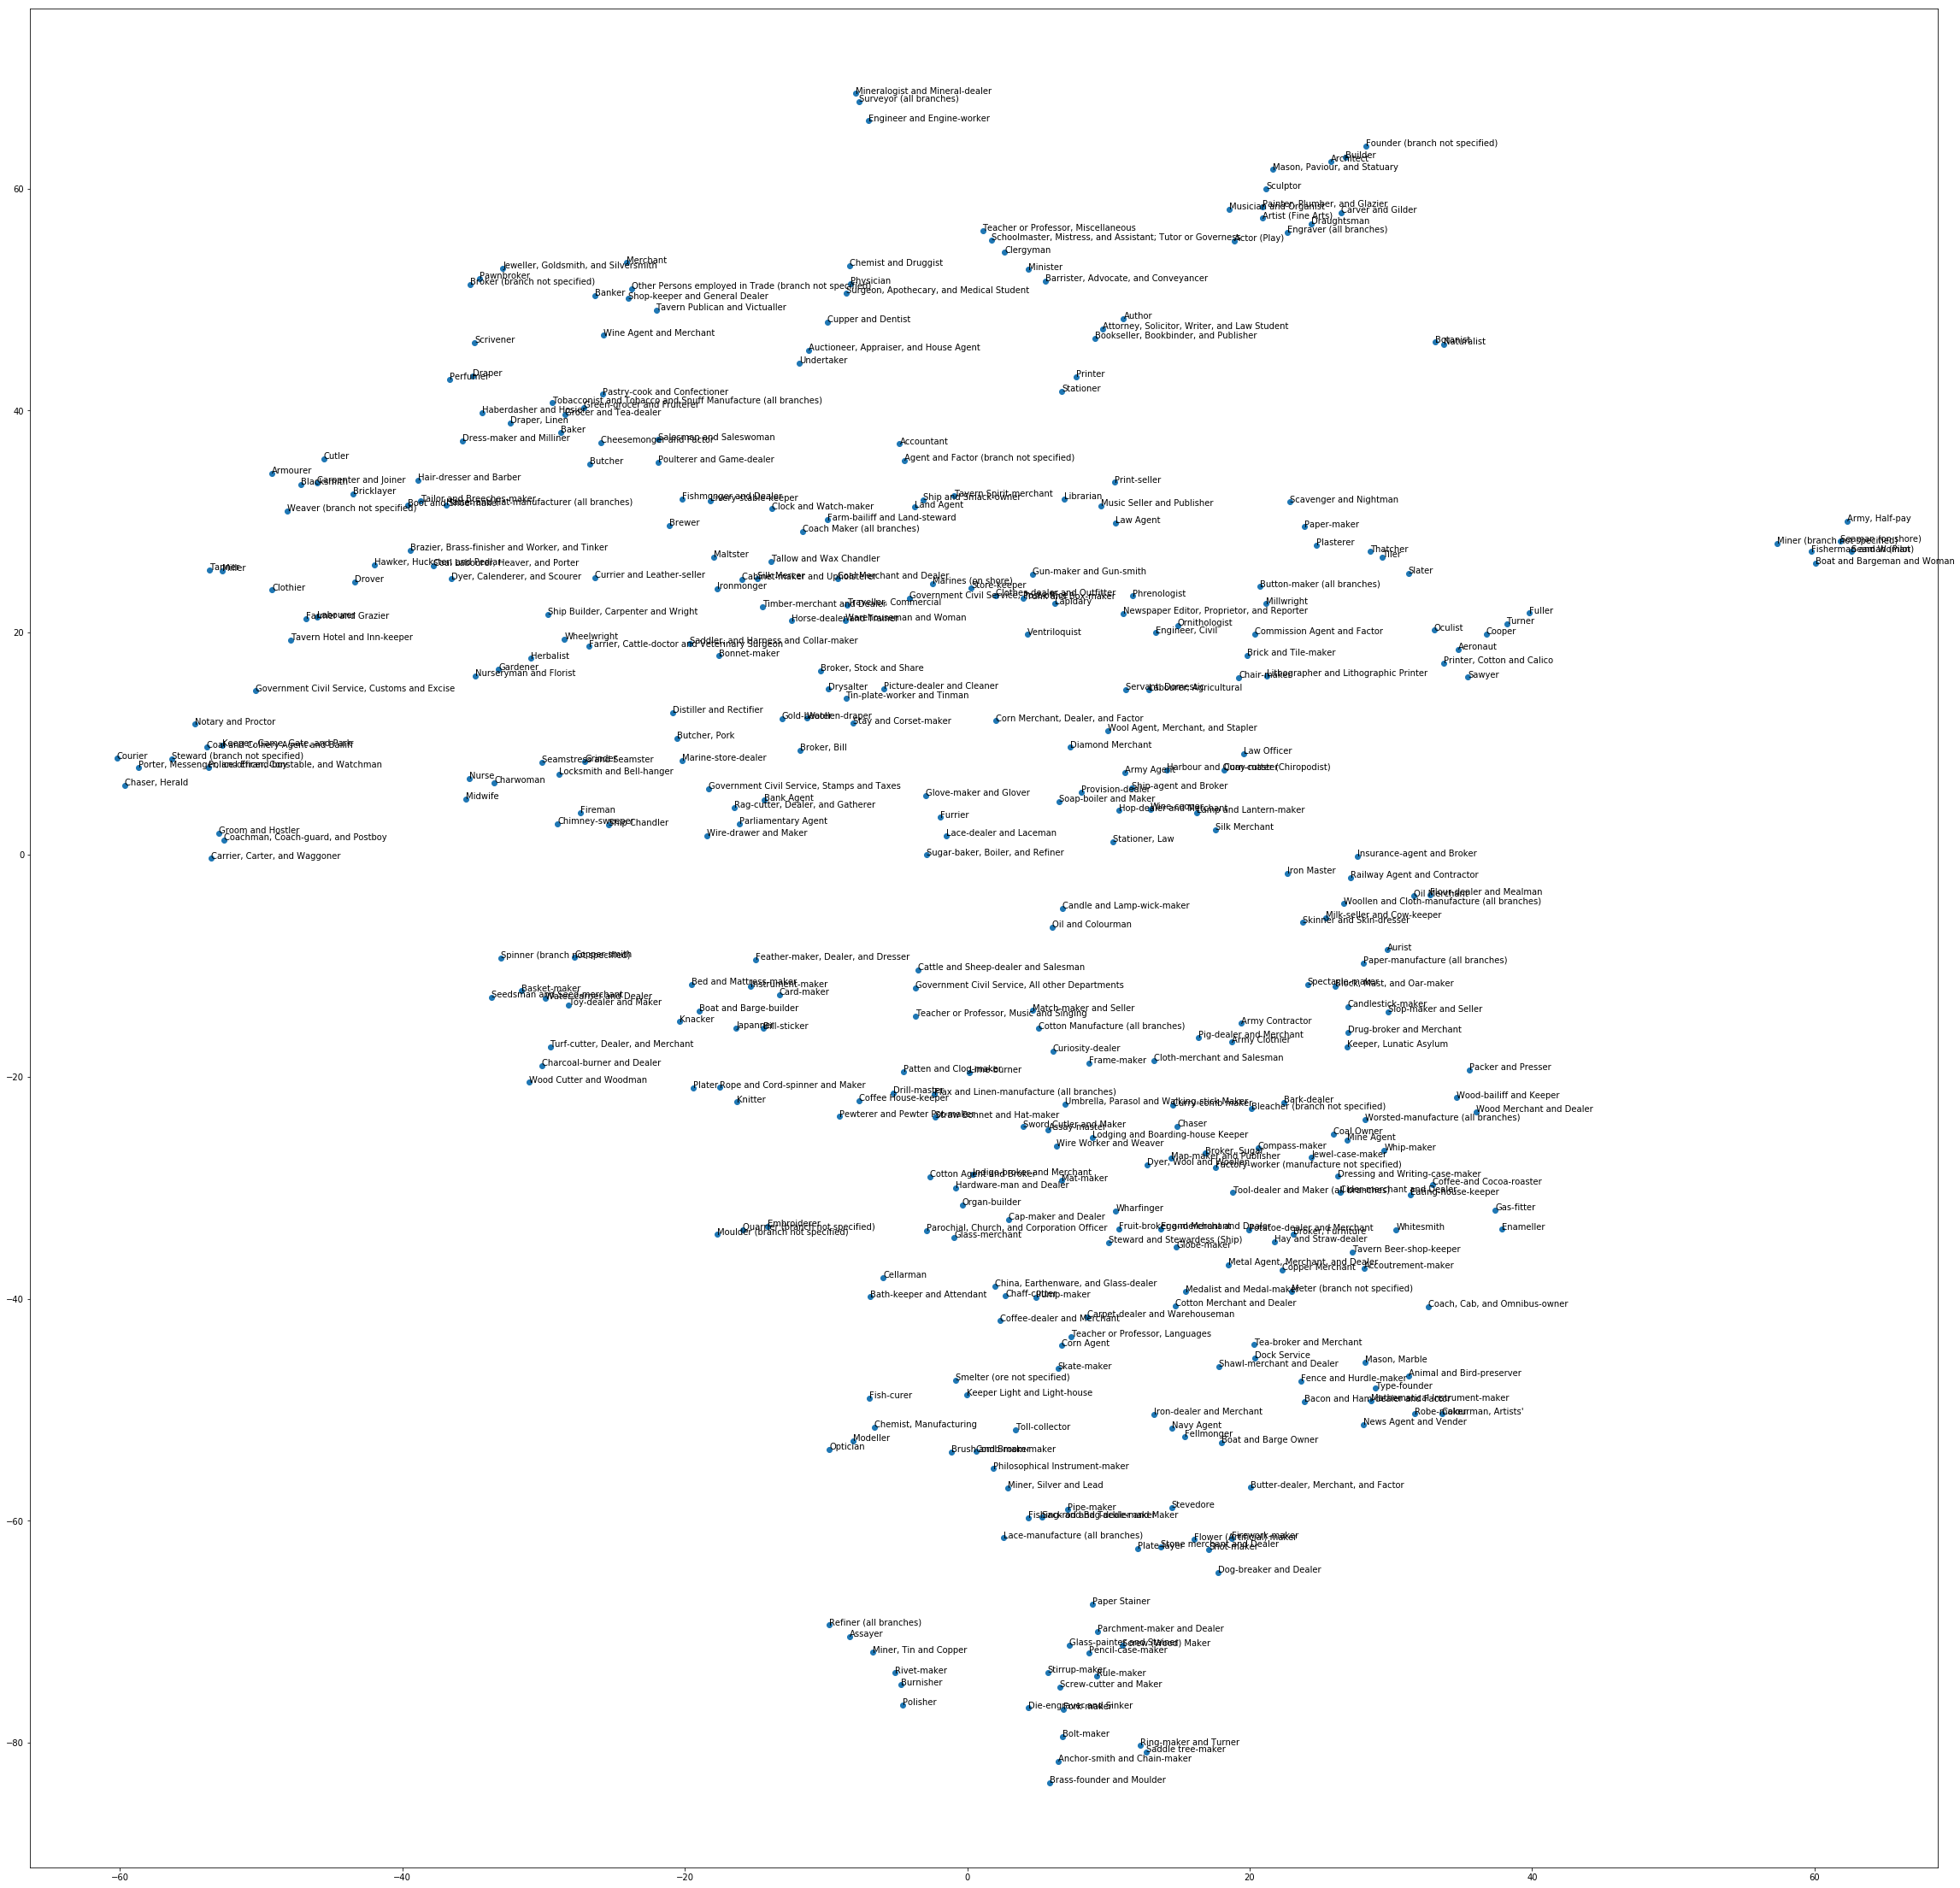

In [261]:
plt.rcParams["figure.figsize"] = (40,40)
plt.scatter(tsne[:,0], tsne[:,1])
for label, x, y in zip(occ_names, tsne[:, 0], tsne[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')